In [13]:
from lib.controller import Controller
from lib.automation import FileDetector
from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.TSV import RegionExporter
from lib.file.pickle import Pickler
import time
import os
import pandas as pd
from lib.utilities import *

In [2]:
dir_base = "C:/Users/jjudge3/Desktop/Data/"
dir_base = "C:/Users/jjudge3/Desktop/Data/Kate's/"
date = "09-08-21"
kkm_full_roi_id_prefix = '08-09-2021__'
data_dir = dir_base + date +"/"
camera_program = 4

quick_debug_run = False

slice_target = [6, 7, 8, 9, 10, 11]
rec_target = [i for i in range(1,3)]  # 8/9/21 (Kate's)
tbs_recording_no = 5
if date == '07-15-22':
    rec_target = [i for i in range(0,17)]  # 7/15
    tbs_recording_no = 5
if date == '07-22-22' and slice_target == 1:
    rec_target = [i for i in range(0,18)]  # 7/19
    tbs_recording_no = 4
if date == '07-22-22' and slice_target == 2:
    rec_target = [i for i in range(0,16)]  
    tbs_recording_no = 5
if date == '07-26-22' and slice_target == 1:
    rec_target = [i for i in range(0,19)]  
    tbs_recording_no = 6
if date == '07-26-22' and slice_target == 2:
    rec_target = [i for i in range(0,16)]  
    tbs_recording_no = 4
if date == "11-30-21":
    rec_target = [2]

load_dic = False
num_regions_to_export = 5  # max number of regions per record to export to PhotoZ
process_all = False  # overrides slice/rec target to process all files

time_course_types = ['Max', 'Avg', 'Num ROIs', 'df/f']
time_course_choice = 2  # index

# recording schedule
int_trial = 10
num_trial = 5
int_recording = 45

actual_int_recording = int_trial * num_trial + int_recording

#cluster settings
sampling_size = 100000
k_cluster = 95  # set to None for AIC elbow plotting
# cluster filter settings
n_pixel_cutoff = 3  # maximum cluster size allowed
average_snr_cutoff_percentile = 50  # cluster-specific percentile

# save time loading and clustering data by loading a saved run
save = True
restore_pickle = None  # saved run index to load, or None. 
save_pickle_index = 0  # save run index to save, or None. Will find higher index to avoid overwrite
if not save:  # then load
    restore_pickle, save_pickle_index = save_pickle_index, restore_pickle

In [3]:
# read in 8-bit single TIF images to array, apply same cropping/binning
single_images = {}
dic_dir = data_dir + "dic/"
cam_settings = CameraSettings().get_program_settings(camera_program)
binning = int(cam_settings['height'] / 80)
    
if quick_debug_run:
    slice_target = slice_target[:1]
    rec_target = rec_target[:1]
    k_cluster = 10

if load_dic and restore_pickle is None:
    TIFLoader(dic_dir, cam_settings, binning).load_files(single_images, slice_target=slice_target[0])

06-01-02_snr.txt
07-01-02_snr.txt
08-01-02_snr.txt
09-01-01_snr.txt
10-01-01_snr.txt
11-01-01_snr.txt
ImageZ-06-01-02_snr.tsv
ImageZ-07-01-02_snr.tsv
ImageZ-08-01-02_snr.tsv
ImageZ-09-01-01_snr.tsv
ImageZ-10-01-01_snr.tsv
ImageZ-11-01-01_snr.tsv
ROIs-highest-06-01-02_snr.txt
invalid literal for int() with base 10: 'ROIs'
ROIs-highest-07-01-02_snr.txt
invalid literal for int() with base 10: 'ROIs'
ROIs-highest-08-01-02_snr.txt
invalid literal for int() with base 10: 'ROIs'
ROIs-highest-09-01-01_snr.txt
invalid literal for int() with base 10: 'ROIs'
ROIs-highest-10-01-01_snr.txt
invalid literal for int() with base 10: 'ROIs'
ROIs-highest-11-01-01_snr.txt
invalid literal for int() with base 10: 'ROIs'
ROIs85-06-01-02_snr.txt
invalid literal for int() with base 10: 'ROIs85'
ROIs85-07-01-02_snr.txt
invalid literal for int() with base 10: 'ROIs85'
ROIs85-08-01-02_snr.txt
invalid literal for int() with base 10: 'ROIs85'
ROIs85-09-01-01_snr.txt
invalid literal for int() with base 10: 'ROIs85'


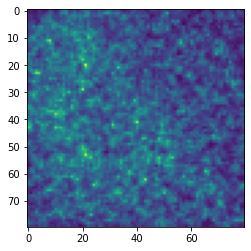

In [33]:
# read in non-normalized maps exported from PhotoZ: 
#  pre-stim SNR, stim SNR, and stim MaxAmp (DAT files)
dat_dir = data_dir + "converted_zda/"
if restore_pickle is None:
    for filename in os.listdir(dat_dir):
        print(filename)
        if (filename.endswith(".dat") or filename.endswith(".txt")):
            sep = "_"
            map_type = filename[:3]
            name_parse = filename.split('.')[0][-8:]
            
            # for tolerating Kate's file naming convertion for SNR maps
            tmp = filename.split('.')[-2]
            if tmp.endswith('_snr'):
                name_parse = tmp[:-4]
                map_type = 'SNR'
                sep = "-"
            elif tmp.startswith('ROIs'):
                map_type = "KKM_ROIs"
                name_parse = tmp[5:]
                sep = "-"
            
            try:
                slic, loc, rec = [int(x) for x in name_parse.split(sep)]
            except ValueError as e:
                print(e)
                continue
            if slic not in single_images:
                single_images[slic] = {}
            if loc not in single_images[slic]:
                single_images[slic][loc] = {}
            if map_type not in single_images[slic][loc]:
                single_images[slic][loc][map_type] = {}
            dat = None
            
            if map_type != "KKM_ROIs":  # Kate's ROIs load later
                dat = np.loadtxt(dat_dir + filename,
                                 delimiter='\t',
                                 usecols=(1,))
                width = int(np.sqrt(dat.shape[0]))
                dat = dat.reshape((width, width))
                if map_type == "SNR" and slic in slice_target and rec in rec_target:
                    plt.imshow(dat)
            single_images[slic][loc][map_type][rec] = {
                'data': dat,
                'filename': filename,
                'width': width}


In [5]:
# record stim amplitudes manually

# for 06-21-22
# single_images[1][1]['stims'] = [100, 100, 100, 80, 80, 60, 60, 40, 40]
# single_images[2][1]['stims'] = [40, 100, 100, 80, 80, 60, 60]
# single_images[3][1]['stims'] = [100, 100, 80, 80, 60, 60]


# for 07-12-22
#single_images[1][1]['stims'] = [80, 60, 60, 50, 40] + [40 for _ in range(6, 24)]


In [6]:
roi = ROI_Identifier()
reg_exp = RegionExporter()

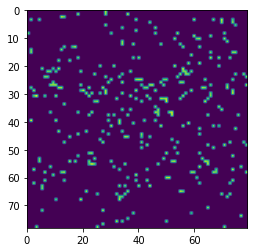

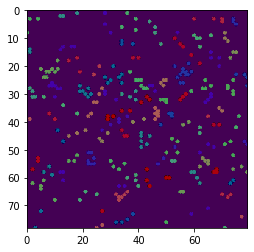

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs85-06-01-02_snr.txt


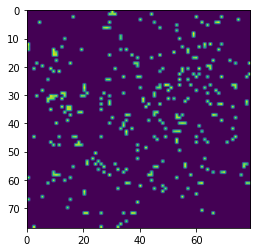

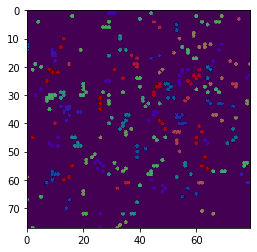

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs90-06-01-02_snr.txt


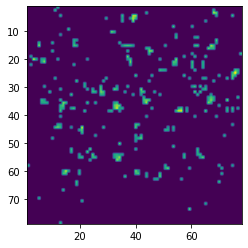

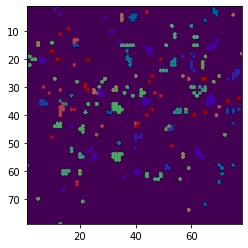

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs95-06-01-02_snr.txt


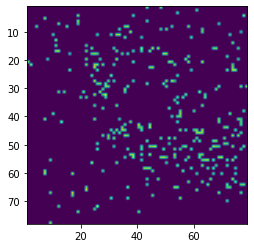

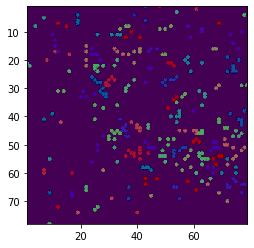

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs85-07-01-02_snr.txt


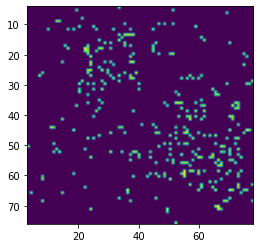

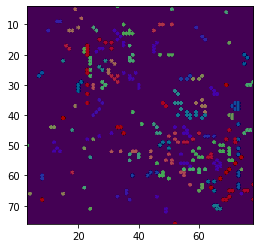

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs90-07-01-02_snr.txt


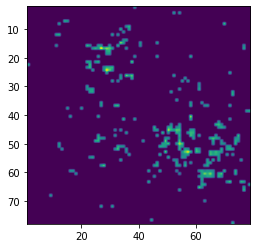

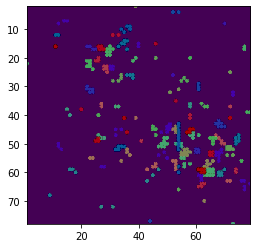

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs95-07-01-02_snr.txt


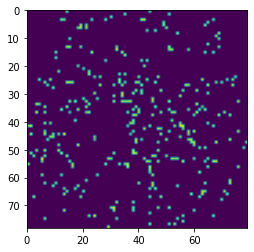

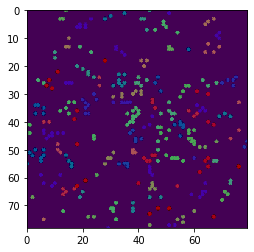

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs85-08-01-02_snr.txt


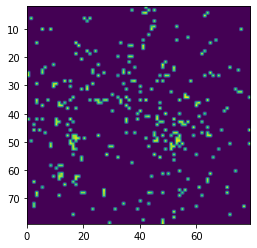

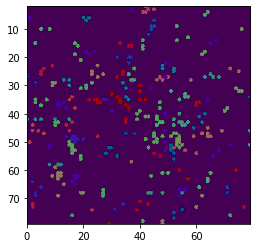

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs90-08-01-02_snr.txt


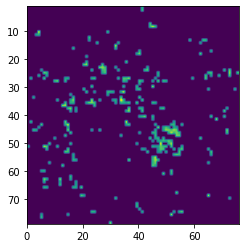

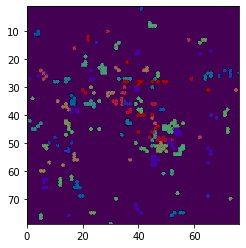

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs95-08-01-02_snr.txt


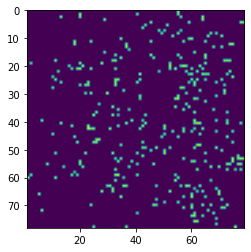

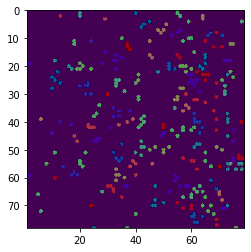

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs85-09-01-01_snr.txt


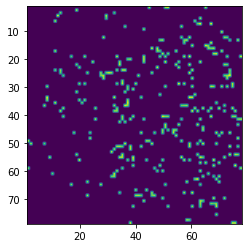

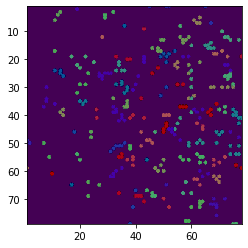

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs90-09-01-01_snr.txt


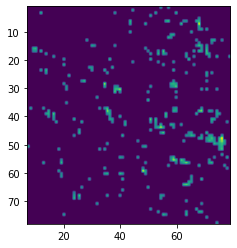

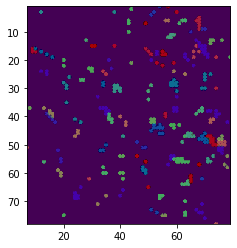

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs95-09-01-01_snr.txt


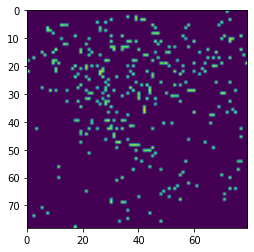

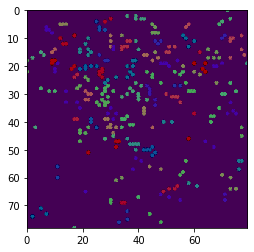

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs85-10-01-01_snr.txt


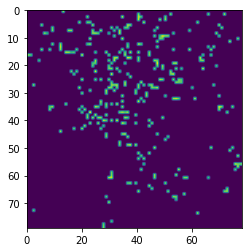

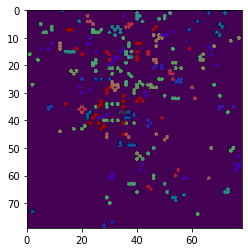

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs90-10-01-01_snr.txt


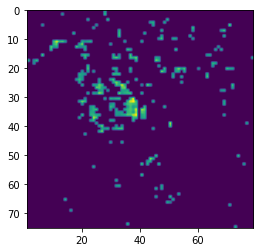

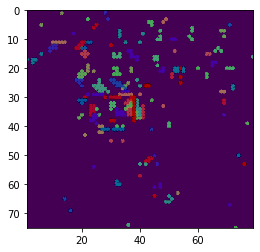

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs95-10-01-01_snr.txt


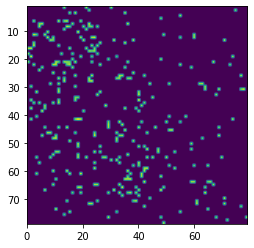

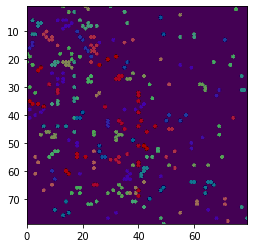

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs85-11-01-01_snr.txt


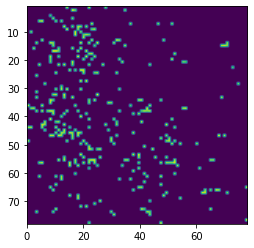

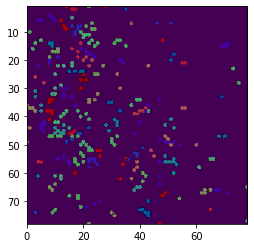

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs90-11-01-01_snr.txt


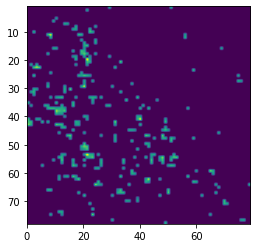

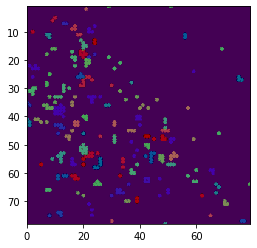

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs95-11-01-01_snr.txt


In [7]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]

percentile_strata = [[80, 85], [85, 90], [90, 95], [95, 100]]
percentile_strata = [[85, 90], [90, 95], [95, 100]]


for slic in single_images:
    for loc in single_images[slic]:
        
        # DICs
        #img = single_images[slic][loc]['i']
        #electrode = single_images[slic][loc]['e']
        #fluor = single_images[slic][loc]['f']
        for rec in single_images[slic][loc]['SNR']:
            
            if (process_all or (slic in slice_target and rec in rec_target)) and restore_pickle is None:
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = []

                for stratum in percentile_strata:
                    low_cutoff, hi_cutoff = stratum

                    sampled_points = roi.generate_points(snr, n_points=sampling_size, 
                                                         percentile_cutoff=low_cutoff,
                                                         upper_cutoff=hi_cutoff)

                    roi.heatmap_of_scatter(sampled_points, w, h) # should look similar
                
                    k = k_cluster

                    if k is None:
                        # use AIC and elbow method, then enter choice of k above
                        roi.find_gmm_cluster_number(sampled_points, k_start=30, k_step=10, k_search=91)
                        break
                    else: # after manually selecting k
                        labels = roi.gaussian_mixture_model(sampled_points, k, show=False)

                        roi.draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)

                        # print ROIs to a DAT file to be loaded into PhotoZ
                        filename = dat_dir + "ROIs" + str(low_cutoff) + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        regions = roi_write.export_clusters(filename, labels, sampled_points, w, limit=num_regions_to_export)
                        all_regions_by_pixel = roi_write.get_regions_by_pixel()
                        # regions is in format of doubly-nested list of PhotoZ diode numbers

                        cluster_objs = []
                        for px_region in all_regions_by_pixel:
                            cluster_objs.append(Cluster(px_region, w))
                            
                        cluster_strata.append(cluster_objs)
                        single_images[slic][loc]['SNR'][rec]['cluster_strata'] = cluster_strata

In [8]:
# save/load point: pickle all objects to "last run" in current working directory. Also loads if restore_pickle is True
Pickler(dir_base, date, save_pickle_index, restore_pickle, slice_target[0]).process_pickle(single_images)

Wrote: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/saved_run2-6.pickle


In [9]:
for slic in single_images:
    for loc in single_images[slic]:
        print(slic, loc)
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic in slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])
                
                # Split non-contiguous clusters until contiguous
                for stratum in cluster_strata:
                    extra_clusters = []
                    for cluster in stratum:
                        new_clusters = cluster.attempt_split()
                        extra_clusters += new_clusters
                    stratum += extra_clusters
                
                # Filter clusters by size
                for stratum in cluster_strata:
                    for i in range(len(stratum)-1, -1, -1):  # strata 1 is the lower-SNR strata
                        if stratum[i].get_cluster_size() > n_pixel_cutoff:
                            del stratum[i]
                            
                # Filter clusters by avg SNR
                for stratum in cluster_strata:
                    if len(stratum) > 1:
                        stratum_snrs = np.array([cluster.get_cluster_snr(snr) for cluster in stratum])
                        snr_cutoff = np.percentile(stratum_snrs, average_snr_cutoff_percentile)
                        for i in range(len(stratum_snrs)-1, -1, -1):
                            if stratum_snrs[i] < snr_cutoff:
                                del stratum[i]

                # filter adjacent (touching) clusters of different clusters -- remove the lower-SNR one. 
                for i in range(len(cluster_strata)):
                    stratum1 = cluster_strata[i]
                    for j in range(i+1, len(cluster_strata)):
                        stratum2 = cluster_strata[j]
                        for ic_1 in range(len(stratum1)-1, -1, -1):  # stratum 1 is the lower-SNR stratum
                            for c2 in stratum2:
                                if stratum1[ic_1].is_adjacent_to(c2):
                                    del stratum1[ic_1]
                                    break
                                    
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])


6 1
Strata sizes (# clusters): [95, 95, 95]
Strata sizes (# clusters): [0, 0, 74]
7 1
Strata sizes (# clusters): [95, 95, 95]
Strata sizes (# clusters): [0, 0, 71]
8 1
Strata sizes (# clusters): [95, 95, 95]
Strata sizes (# clusters): [0, 0, 72]
9 1
Strata sizes (# clusters): [95, 95, 95]
Strata sizes (# clusters): [0, 0, 80]
10 1
Strata sizes (# clusters): [95, 95, 95]
Strata sizes (# clusters): [0, 0, 68]
11 1
Strata sizes (# clusters): [95, 95, 95]
Strata sizes (# clusters): [0, 0, 68]


Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs-highest-06-01-02_snr.txt
3


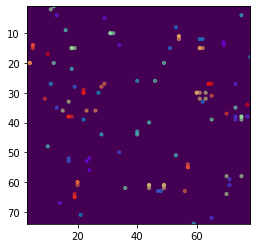

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs-highest-07-01-02_snr.txt
3


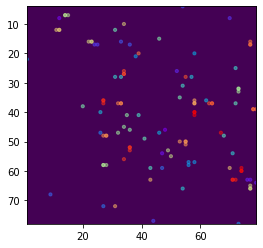

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs-highest-08-01-02_snr.txt
3


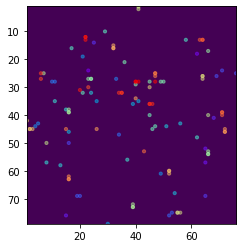

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs-highest-09-01-01_snr.txt
3


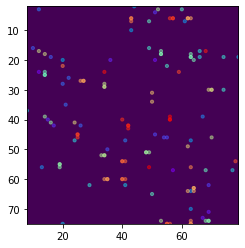

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs-highest-10-01-01_snr.txt
3


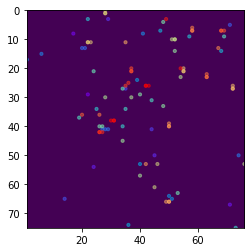

Regions written to: C:/Users/jjudge3/Desktop/Data/Kate's/09-08-21/converted_zda/ROIs-highest-11-01-01_snr.txt
3


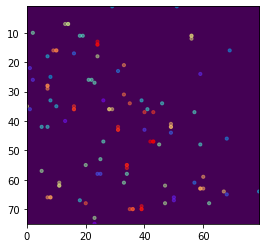

In [10]:
for slic in single_images:
    for loc in single_images[slic]:
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic in slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                                                    
                # consolidate strata and show all surviving ROIs
                plt.clf()
                j_label = 0
                for i in range(len(cluster_strata)):
                    stratum = cluster_strata[i]
                    if len(stratum) > 0:
                        pixels = []
                        labels = []
                        for c in stratum:
                            new_pixels = c.get_pixels()
                            pixels += new_pixels
                            labels += [j_label for _ in range(len(new_pixels))]
                            j_label += 1
                        pixels = np.array(pixels)
                        roi.draw_gmm_enclosures(pixels, labels, a=0.5, s=10, show=False, plot_sample_heatmap=False)
                        filename = dat_dir + "ROIs-highest" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        
                        # export only the highest SNR clusters.
                        regions = roi_write.export_clusters(filename, labels, pixels, w, 
                                                            limit=num_regions_to_export,
                                                            snr=snr)

                        # Export ROIs to ImageZ format for region drawing
                        all_px_regions = roi_write.get_regions_by_pixel()
                        filename = dat_dir + "ImageZ" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        filename = filename[:-4] + ".tsv"
                        reg_exp.export(filename, all_px_regions)
                        
                        single_images[slic][loc]['SNR'][rec]['final_ROIs'] = all_px_regions
                        single_images[slic][loc]['SNR'][rec]['final_ROIs_filename'] = filename
                    
                plt.show()

In [26]:
# read in KKM manual ROI filter results
manual_ROI_filename = dir_base + "manual_ROIs.csv"
kkm_manual_ROIs = pd.read_csv(manual_ROI_filename, usecols=["Slice_Loc_Run", "ROI_Id", "Full_ROI_Id"])

# filter to only date's rows
kkm_manual_ROIs = kkm_manual_ROIs[kkm_manual_ROIs["Full_ROI_Id"].str.startswith(kkm_full_roi_id_prefix)]

# split slice_loc_run into separate columns
kkm_manual_ROIs[['slice', 'loc', 'rec']] = kkm_manual_ROIs['Slice_Loc_Run'].str.split('_', 2, expand=True).apply(pd.to_numeric)
kkm_manual_ROIs.drop(['Full_ROI_Id', 'Slice_Loc_Run'], axis=1, inplace=True)

kkm_manual_ROIs

,ROI_Id,slice,loc,rec
3091,1,9,1,3
3092,2,6,1,1
3093,3,8,1,4
3094,4,3,1,3
3095,4,4,1,2
...,...,...,...,...
3400,194,5,1,1
3401,195,5,1,1
3402,196,5,1,1
3403,199,5,1,1


In [32]:
# compare to kate's k-means
roi_write = ROIFileWriter()
for slic in single_images:
    for loc in single_images[slic]:
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic in slice_target and rec in rec_target) and 'KKM_ROIs' in single_images[slic][loc]:
                
                gmm_final_rois = single_images[slic][loc]['SNR'][rec]['final_ROIs']
                w = single_images[slic][loc]['SNR'][rec]['width']
                filename = data_dir + "converted_zda/" + single_images[slic][loc]['KKM_ROIs'][rec]['filename']
                kkm_final_rois = roi_write.read_regions_from_dat(filename)
                
                dummy_cluster = Cluster([], w)
                for region in kkm_final_rois:
                    for i in range(len(region)):
                        region[i] = dummy_cluster.diode_number_to_pt(region[i])
                        
                # index kkm_manual_ROIs to a cached look-up for kkm rois that survive manual filtering
                kkm_final_ROI_lookup = {}
                for idx, row in kkm_manual_ROIs[(kkm_manual_ROIs['slice'] == slic) & 
                                                (kkm_manual_ROIs['rec'] == rec) &
                                                (kkm_manual_ROIs['loc'] == loc)].iterrows():
                    if row['ROI_Id'] not in kkm_final_ROI_lookup:
                        kkm_final_ROI_lookup[row['ROI_Id']] = True
                
                if len(kkm_final_ROI_lookup.keys()) < 1:
                    print("No manual KKM ROIs selection found for slice", slic, ", loc", loc, ", rec", rec)
                    continue
                        
                print(slic, loc, rec, kkm_manual_ROIs[(kkm_manual_ROIs['slice'] == slic) & 
                                                (kkm_manual_ROIs['rec'] == rec) &
                                                (kkm_manual_ROIs['loc'] == loc)])
                
                # convert kkm to labelled point list and also filter out based on kkm_manual_ROIs
                sampled_pts = []
                labels = []
                for lab in range(len(kkm_final_rois)):
                    if lab+1 in kkm_final_ROI_lookup:
                        region = kkm_final_rois[lab]
                        for pt in region:
                            sampled_pts.append(pt)
                            labels.append(lab+1)
                roi.draw_gmm_enclosures(np.array(sampled_pts), 
                                        labels, 
                                        a=0.5, 
                                        s=10, 
                                        show=True, 
                                        plot_sample_heatmap=False)
                
                # compute overlap between methods.
                incident_array = np.zeros((w, w), dtype=np.int8)
                px_overlap_ct = 0
                possible_overlap_map = {}  # maps GMM index -> list of KKM indices
                combined_px_total = 0
                
                for cluster_index in range(len(gmm_final_rois)):
                    region = gmm_final_rois[cluster_index]
                    for pt in region:
                        combined_px_total += 1
                        y, x = pt
                        incident_array[x, y] = cluster_index
                        
                
                for cluster_index in range(len(kkm_final_rois)):
                    region = kkm_final_rois[cluster_index]
                    already_added = False
                    for pt in region:
                        y, x = pt
                        combined_px_total += 1
                        if incident_array[x, y] != 0:
                            px_overlap_ct += 1
                            gmm_index = incident_array[x, y]
                            if gmm_index not in possible_overlap_map:
                                possible_overlap_map[gmm_index] = []
                            if not already_added:
                                possible_overlap_map[gmm_index].append(cluster_index)
                                already_added = True
                            incident_array[x, y] = -1
                coincident_arr = incident_array < 0
                combined_px_total -= px_overlap_ct  # subtract double counts
                
                plt.clf()
                plt.imshow(coincident_arr)
                plt.show()
                print("Number of overlapping pixels:", px_overlap_ct)
                cluster_overlap_ct = len([len(possible_overlap_map[k]) for k in possible_overlap_map])
                print("map of clusters from KKM that overlap with at least one from GMM:", 
                      cluster_overlap_ct,
                      "\ntotal pixels both methods:",
                      combined_px_total,
                      '\n\n',
                      possible_overlap_map)       

No manual KKM ROIs selection found for slice 6 , loc 1 , rec 2
No manual KKM ROIs selection found for slice 7 , loc 1 , rec 2
No manual KKM ROIs selection found for slice 8 , loc 1 , rec 2
No manual KKM ROIs selection found for slice 9 , loc 1 , rec 1
No manual KKM ROIs selection found for slice 10 , loc 1 , rec 1
No manual KKM ROIs selection found for slice 11 , loc 1 , rec 1
